In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [176]:
TYPES_TO_COLORS = {
    "arugula": [61, 123, 0],
    "borage": [255, 174, 1],
    "cilantro": [1, 124, 93],
    "green-lettuce": [50, 226, 174],
    "kale": [49, 49, 226],
    "radiccio": [185, 180, 42],
    "red-lettuce": [145, 50, 226],
    "sorrel": [255, 0, 0],
    "swiss-charge": [226, 50, 170],
    "turnip": [254, 85, 89]
}

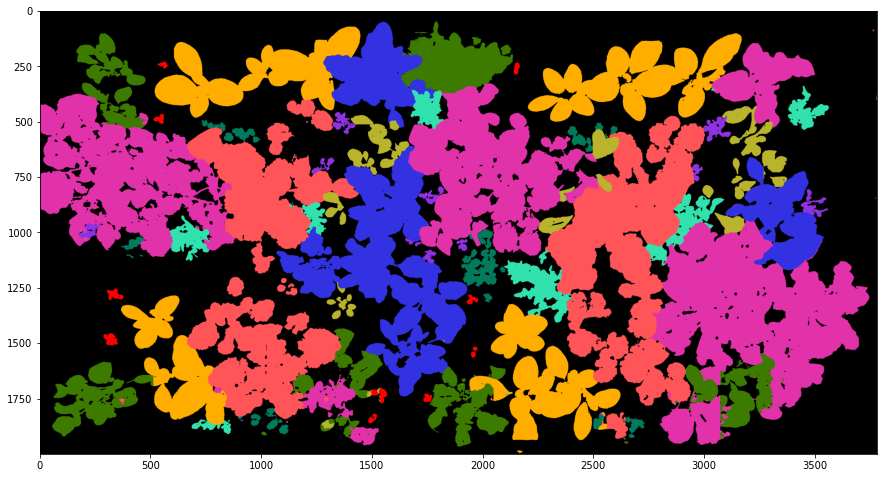

In [196]:
predicted_mask = cv2.cvtColor(cv2.imread('predicted.png'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 12))
plt.imshow(predicted_mask)

In [191]:
def convert_from_shape_to_circle(mask):
    plant_circles = {}
    for plant_type in TYPES_TO_COLORS:
        binary_mask = prepare_binary_mask(plant_type, mask)
        gray_scaled_mask = cv2.cvtColor(binary_mask, cv2.COLOR_BGR2GRAY)
        inverted = cv2.bitwise_not(binary_mask)
        contours, hierarchy = cv2.findContours(gray_scaled_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # Invert the mask for clearer outline of the convex hull.
        circles = []
        for cnt in contours:
            hull = cv2.convexHull(cnt)
            pair = approximate_circle(inverted, hull)
            circles.append(pair)
        merged = merge_circles(circles)
        merged = [circle for circle in merged if circle[1] >= 10]
        plant_circles[plant_type] = merged
        
    canvas = np.full(mask.shape, [255, 255, 255]).astype(np.uint8)
    for plant_type in plant_circles:
        color = TYPES_TO_COLORS[plant_type]
        for plant_circle in plant_circles[plant_type]:
            centroid = plant_circle[0]
            radius = plant_circle[1]
            canvas = cv2.circle(inverted, centroid, 2, tuple(color), thickness=-1)
            canvas = cv2.circle(inverted, centroid, int(radius), tuple(color), thickness=2)
        canvas = clear_canvas(canvas)
    return canvas, plant_circles

In [193]:
circles, mapping = convert_from_shape_to_circle(predicted_mask)

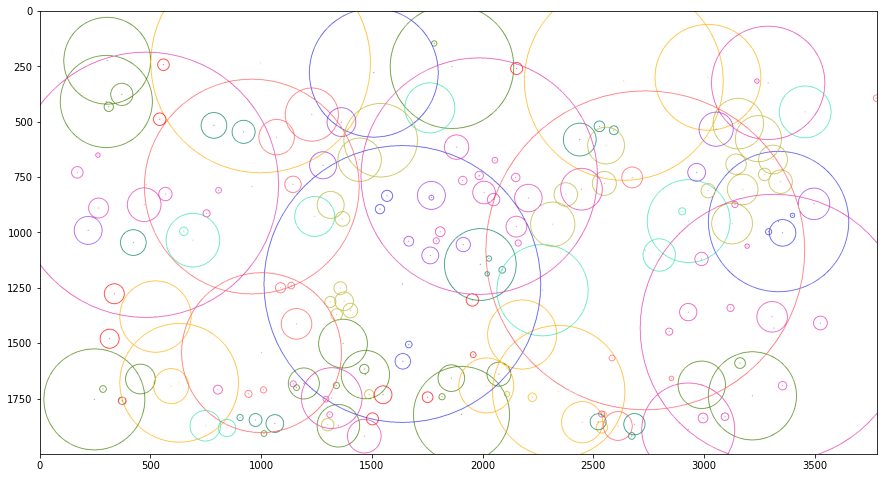

In [194]:
plt.figure(figsize=(15, 12))
plt.imshow(circles)

In [145]:
def prepare_binary_mask(plant_type, mask):
    color = TYPES_TO_COLORS[plant_type]
    offset = 5
    indices = np.where(np.all(np.abs(mask - np.full(mask.shape, color)) <= offset, axis=-1))
    coordinates = zip(indices[0], indices[1])
    binary_mask = np.full(mask.shape, (0, 0, 0))
    for coord in coordinates:
        binary_mask[coord[0], coord[1]] = [255, 255, 255]
    binary_mask = binary_mask.astype(np.uint8)
    return binary_mask

In [179]:
def clear_canvas(canvas):
    indices = np.where(np.all(np.abs(canvas - np.full(canvas.shape, [0, 0, 0])) <= 3, axis=-1))
    coordinates = zip(indices[0], indices[1])
    for coord in coordinates:
        canvas[coord[0], coord[1]] = [255, 255, 255]
    return canvas

In [139]:
binary_mask = prepare_binary_mask('swiss-charge')

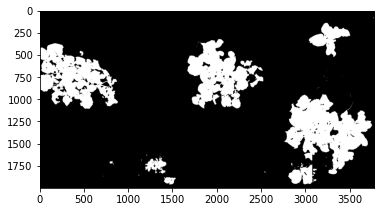

In [140]:
plt.imshow(binary_mask)

In [141]:
gray_scaled_mask = cv2.cvtColor(binary_mask, cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(gray_scaled_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [142]:
def lie_within(c1, c2, offset=50): 
    x1, x2 = c1[0][0], c2[0][0]
    y1, y2 = c1[0][1], c2[0][1]
    r1, r2 = c1[1], c2[1]
    distSq = ((x1 - x2)**2+ (y1 - y2)**2)**(0.5) 
    return distSq <= r1 - r2 + offset

In [143]:
def merge_circles(circles):
    circles.sort(key=lambda pair: -pair[1])
    circles = set(circles)
    merged = set()
    while len(circles) > 0:
        curr_circle = list(circles)[0]
        circles.remove(curr_circle)
        
        circles_copy = set(circles)
        
        for smaller_circle in circles_copy:
            if lie_within(curr_circle, smaller_circle):
                circles.remove(smaller_circle)
        merged.add(curr_circle)
    return merged

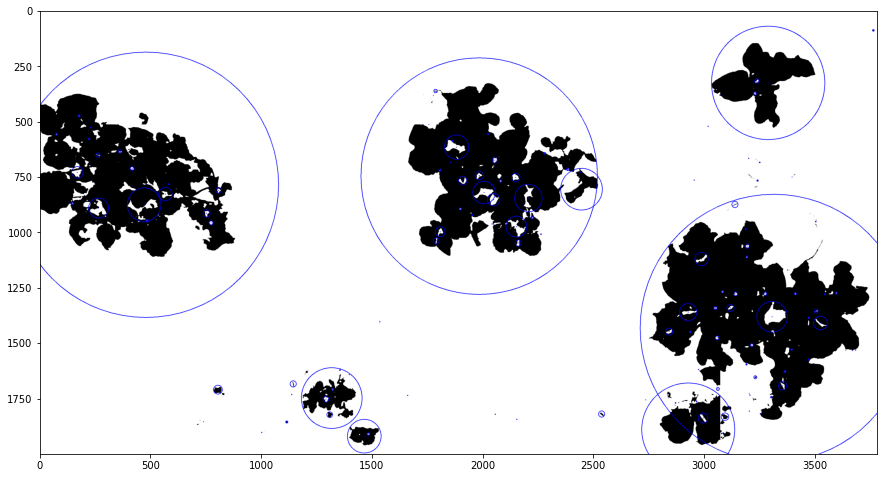

In [144]:
# Invert the mask for clearer outline of the convex hull.
inverted = cv2.bitwise_not(binary_mask)

def approximate_circle(mask, hull):
    hull = np.squeeze(hull, axis=1)
    
    num_points = len(hull)
    centroid_x, centroid_y = 0, 0
    
    # Find the centroid for the hull.
    for point in hull:
        centroid_x += point[0]
        centroid_y += point[1]
    centroid_x //= num_points
    centroid_y //= num_points
    centroid = (centroid_x, centroid_y)
    
    l2_dist = lambda pt1, pt2: ((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2) ** 0.5
    l2_dist_higher_order = lambda pt2: lambda pt1: ((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2) ** 0.5
    
    # Find the point that is farthest away from the centroid.
    max_radius_point = max(hull, key=l2_dist_higher_order(centroid))
    max_radius = l2_dist(max_radius_point, centroid)

    return (centroid, max_radius)

circles = []
for cnt in contours:
    hull = cv2.convexHull(cnt)
    pair = approximate_circle(inverted, hull)
    circles.append(pair)

merged = merge_circles(circles)
for merge in merged: 
    centroid = merge[0]
    radius = merge[1]
    inverted = cv2.circle(inverted, centroid, 2, (0, 0, 255), thickness=-1)
    inverted = cv2.circle(inverted, centroid, int(radius), (0, 0, 255), thickness=2)

plt.figure(figsize=(15, 12))
plt.imshow(inverted)

In [47]:
hull = cv2.convexHull(contours[2])

In [56]:
np.squeeze(hull, axis=1)

array([[2638, 1919],
       [2640, 1921],
       [2645, 1930],
       [2645, 1933],
       [2644, 1934],
       [2641, 1935],
       [2640, 1935],
       [2639, 1934],
       [2631, 1925],
       [2633, 1921],
       [2635, 1919]], dtype=int32)